In [3]:
import snntorch as snn
import torch
from torch import nn

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from IPython import display
from IPython.display import clear_output, HTML, Video

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn

from tqdm.auto import tqdm
from datetime import datetime

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torch.nn.functional import pad, softmax

from math import sqrt

import tonic
import random
from tonic import DiskCachedDataset
import tonic.transforms as transforms

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 0

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
print(f"Running on {device}")

#RUN ONCE
#!echo '/data' >> .gitignore

Running on cuda


### Load DVSGesture data, Utilities functions

In [4]:
class SpikeAnimation():
    def __init__(self, num_plots, color_map = 'coolwarm', frames = None):
        self.to_plot = []
        self.sizes = []
        self.ims = []
        self.color_map = color_map
        self.calc_frames = True
        self.fig, self.axs = plt.subplots(1, num_plots)
        if frames is not None:
            self.frames = frames
            self.calc_frames = False
        return
            
                       
    def add_to_plot(self, three_dim_tensor, size, title):
        assert len(three_dim_tensor.shape) == 3, "Not a three dimensional tensor"
        self.to_plot.append(three_dim_tensor.squeeze(1).detach().numpy())
        self.axs[len(self.to_plot)-1].set_title(title)
        self.sizes.append(size)
        self.ims.append( self.axs[len(self.to_plot)-1].imshow(self.to_plot[-1][0].reshape(size), 
                                      cmap = self.color_map) )
        return
        
    def blit(self, n):
        for iii, image in enumerate(self.ims):
            image.set_array(self.to_plot[iii][n].reshape(self.sizes[iii]))
        return self.ims
    
    def show(self, return_obj=False):
        assert len(self.to_plot) != 0, "No spikes loaded"
        ani = matplotlib.animation.FuncAnimation(self.fig, self.blit, frames = self.frames)
        if return_obj:
            return ani
        return HTML(ani.to_jshtml())

def quick_animate(three_dim_tensor, frames, titles=None, return_obj=False,):
    temp = SpikeAnimation(max(2, len(three_dim_tensor)), frames=frames)
    titles = [" "]*len(three_dim_tensor) if titles is None else titles
    for count, iii in enumerate(three_dim_tensor):
        temp.add_to_plot(iii.cpu(), (iii.shape[-1], iii.shape[-2]), f"{titles[count]}")
    return temp.show(return_obj)

def add_to_class(Class):
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

def pos_neg_to_frame(loader_tensor):
    # combine positive and negative channels of neuromorphic dataset
    return (loader_tensor[:,:,1]-loader_tensor[:,:,0]).movedim(0,1).unsqueeze(2)

In [5]:
dataset = tonic.datasets.DVSGesture(save_to='./data',
                               train=True)
sensor_size = tonic.datasets.DVSGesture.sensor_size

frame_transform = transforms.Compose([transforms.CropTime(max=2_000_000),
                                      transforms.Downsample(spatial_factor=0.5),
                                      transforms.ToFrame(sensor_size=(64,64,2),
                                                         time_window=10_000)
                                     ])
trainset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

random.seed(seed)
batch_size = 1

train_subsample_percent = 30
test_subsample_percent = 10

################# DELETE IF USING WHOLE SET
train_subsample_idx = random.sample(range(0, len(trainset)), int(len(trainset)*train_subsample_percent//100))
test_subsample_idx = random.sample(range(0, len(testset)), int(len(testset)*test_subsample_percent//100))
trainset = Subset(trainset,  train_subsample_idx)
testset= Subset(testset,  test_subsample_idx)
##########################################

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/DVSGesture/test')

cached_dataloader = DataLoader(cached_trainset, batch_size=batch_size)

train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True))

## Initial training

Want to show relationship between weight updates and timing

In [6]:
batch, labels = next(iter(train_loader))
batch.shape

torch.Size([1, 199, 2, 64, 64])

In [10]:
time_step = 1e-3
R = 5
C = 1e-3
threshold=3
lif = snn.Lapicque(R=R, C=C, time_step=time_step, threshold=threshold, reset_mechanism='zero')

In [11]:
def plot_spk_mem_spk(spk_in, mem, spk_out, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  plt.yticks([]) 

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, threshold*2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

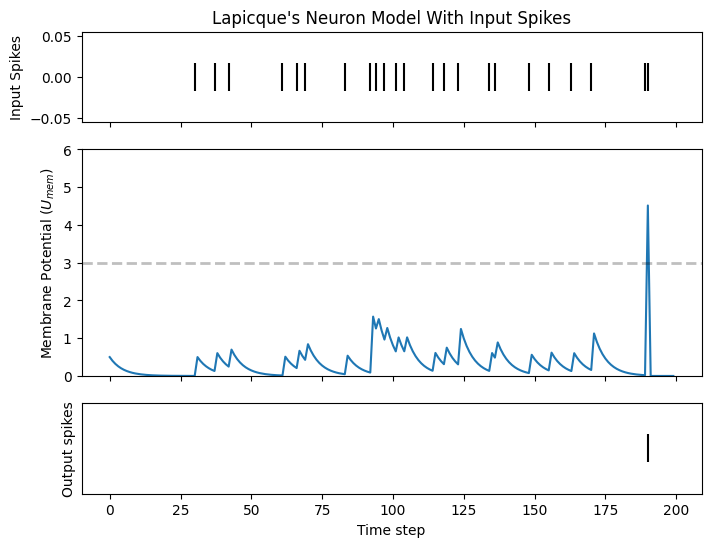

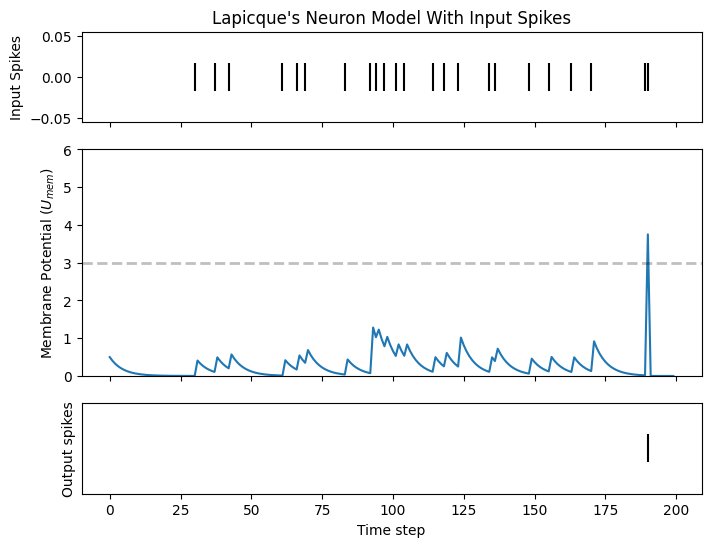

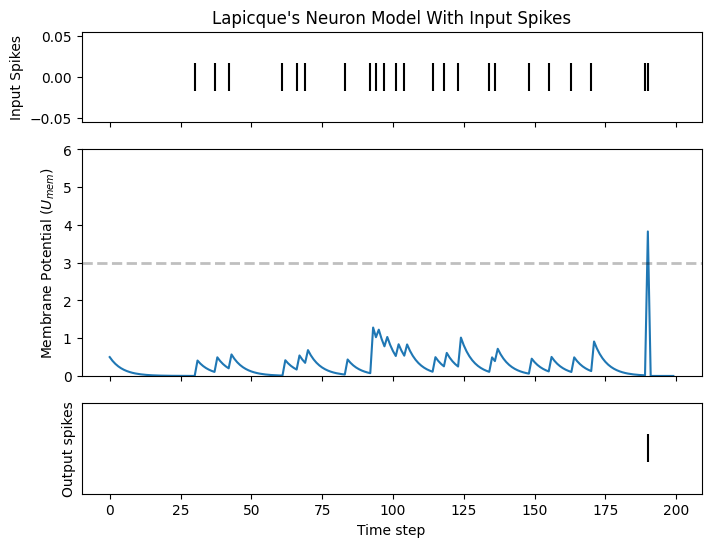

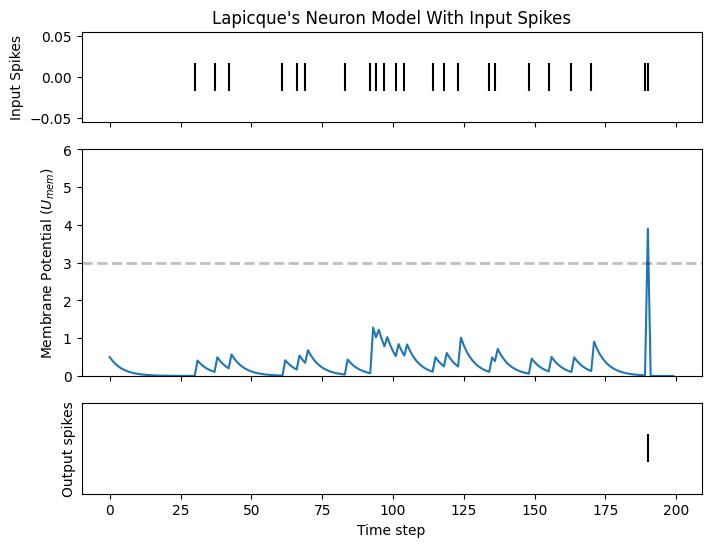

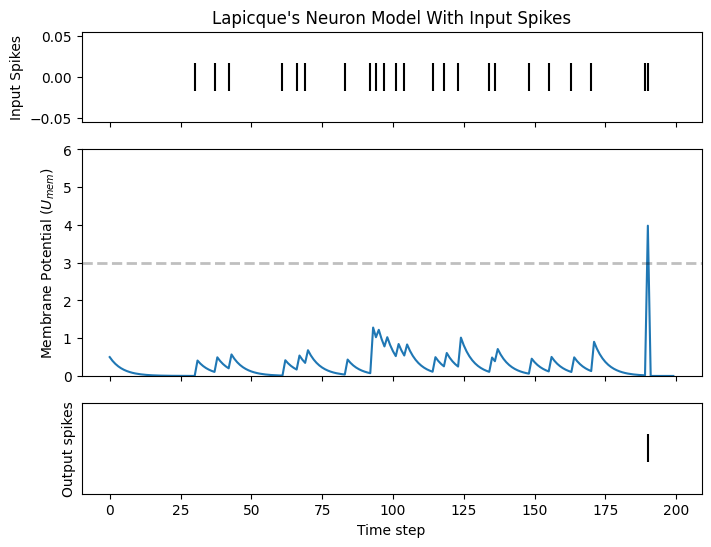

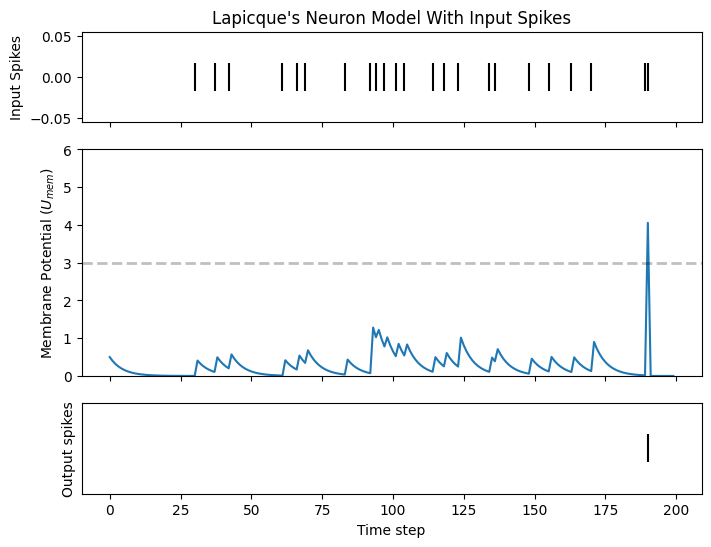

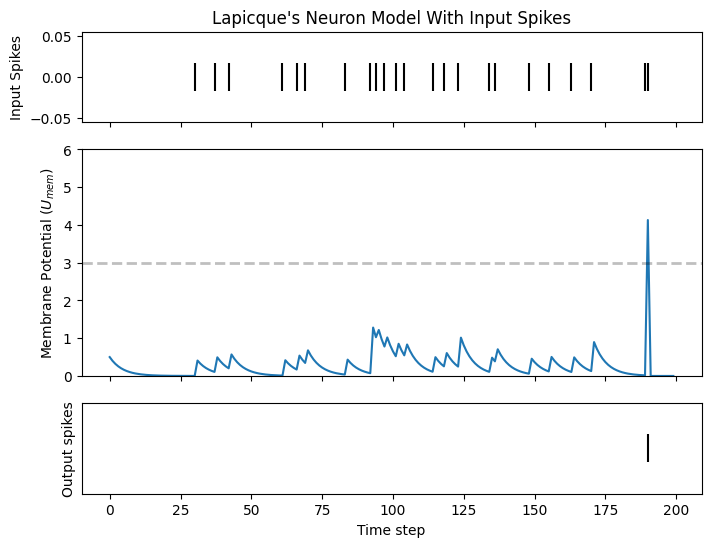

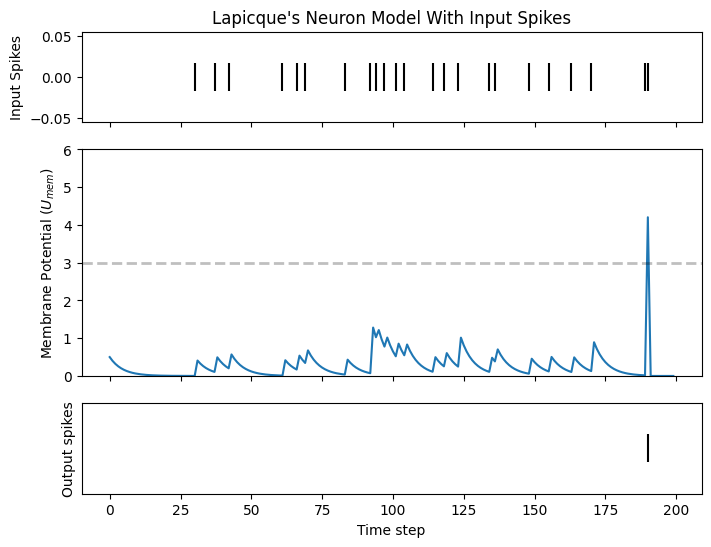

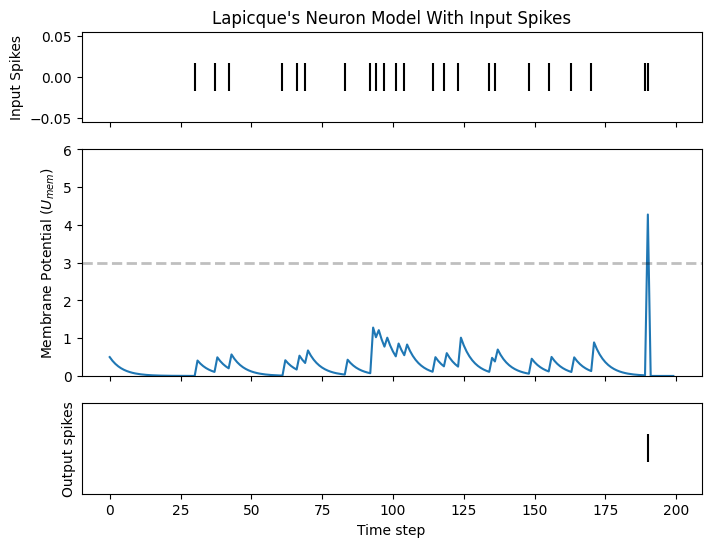

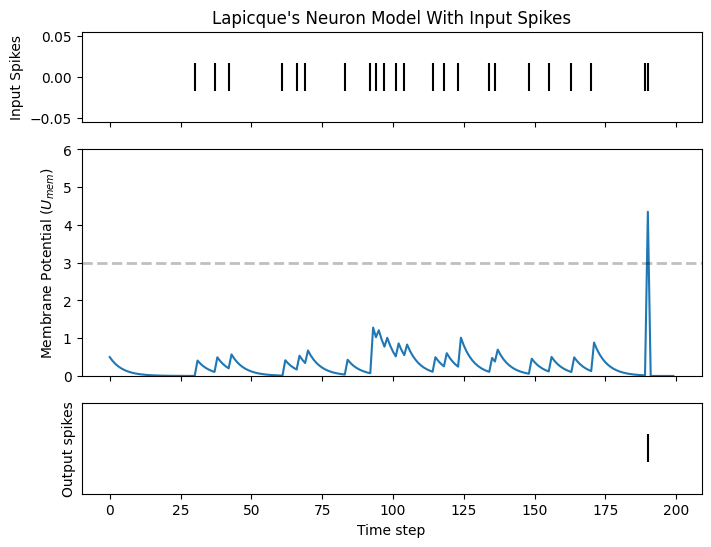

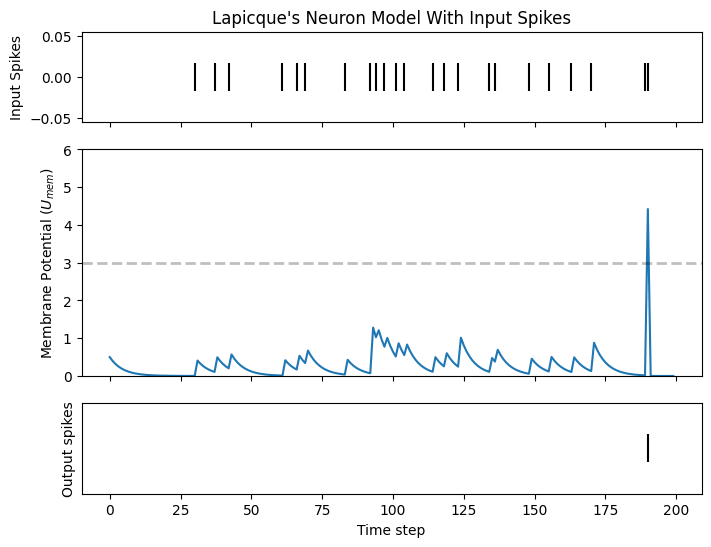

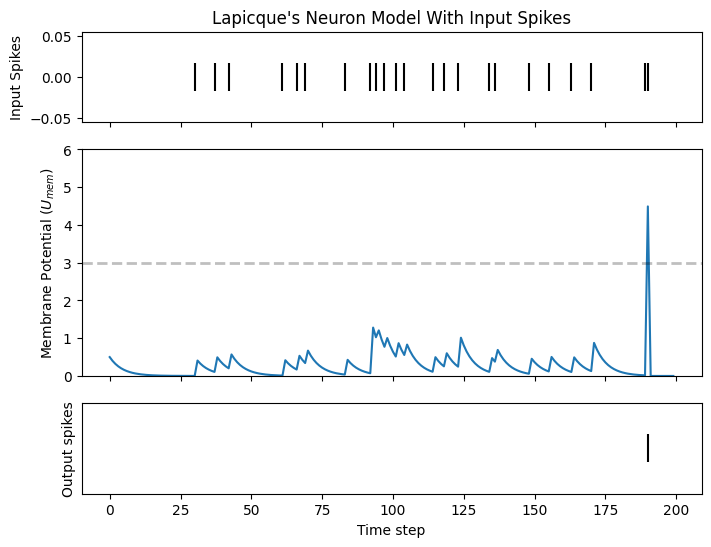

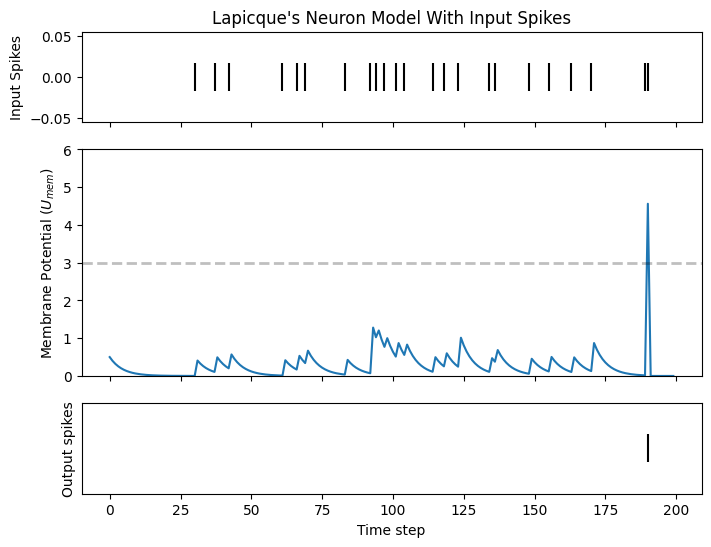

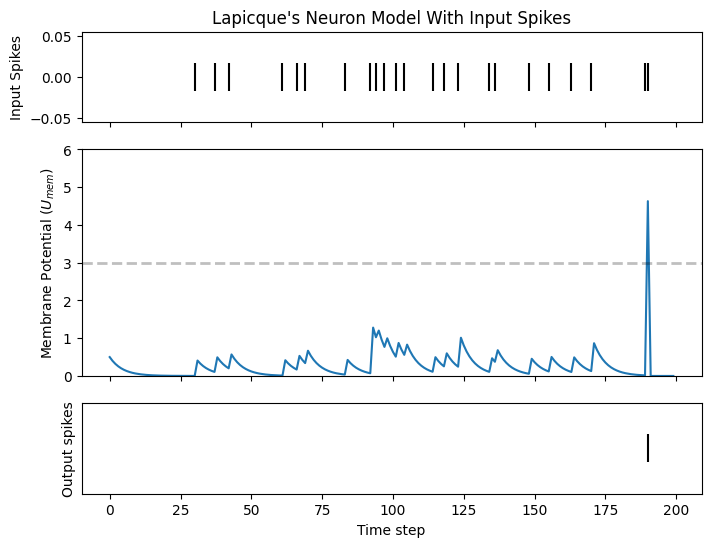

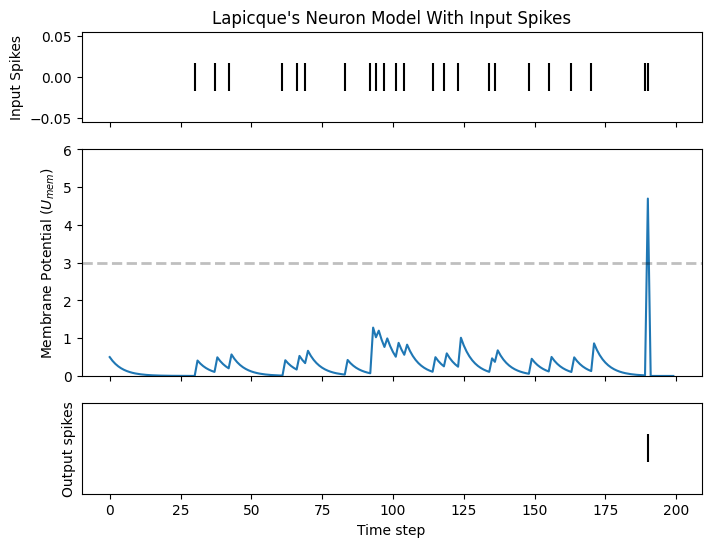

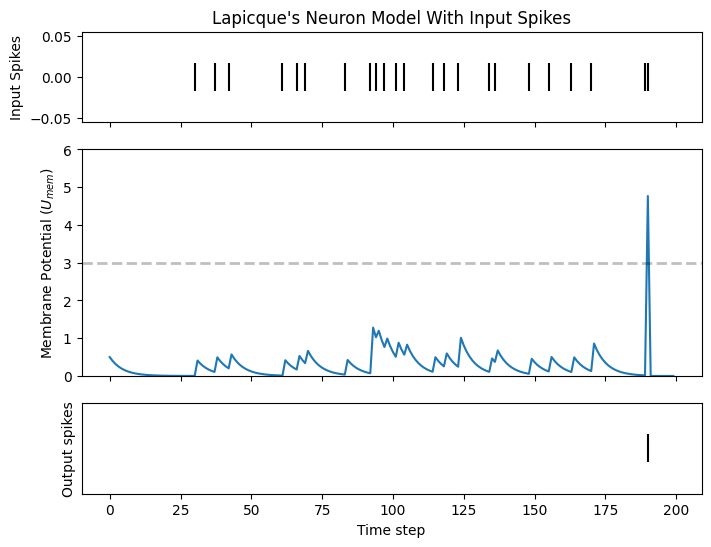

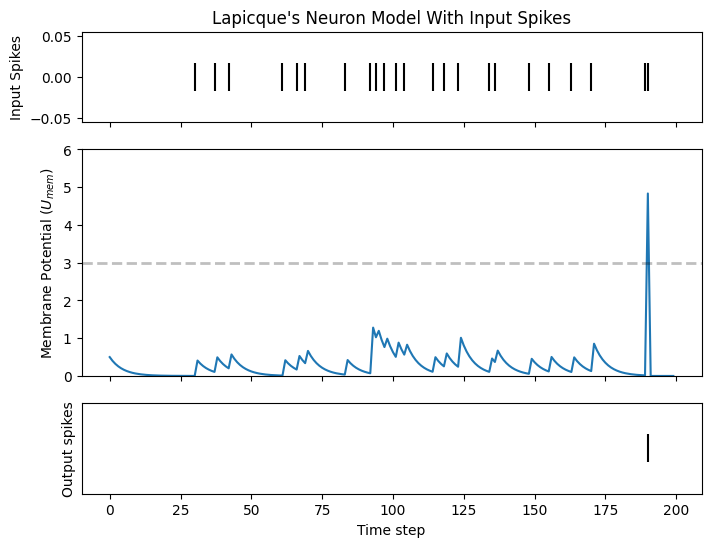

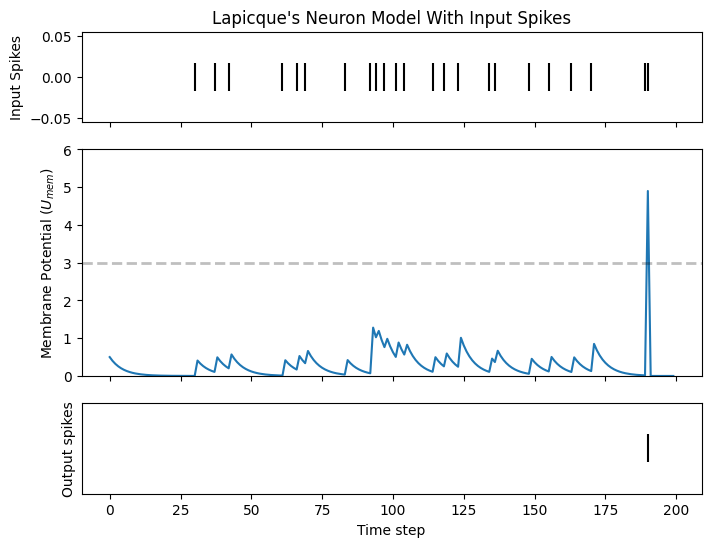

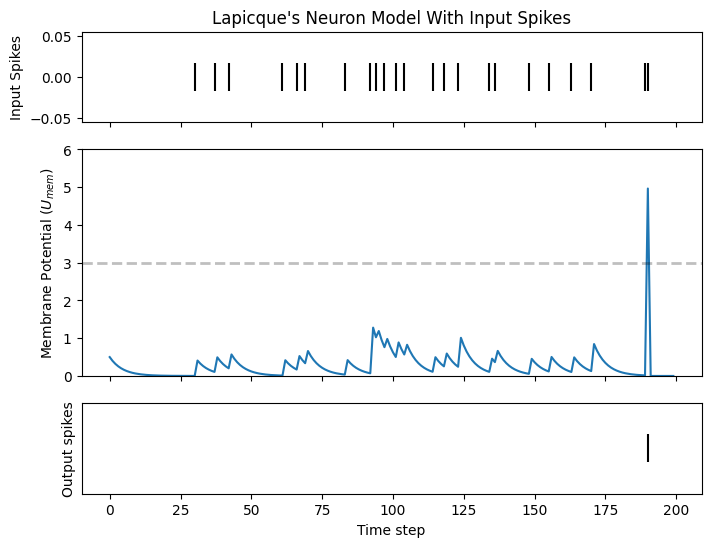

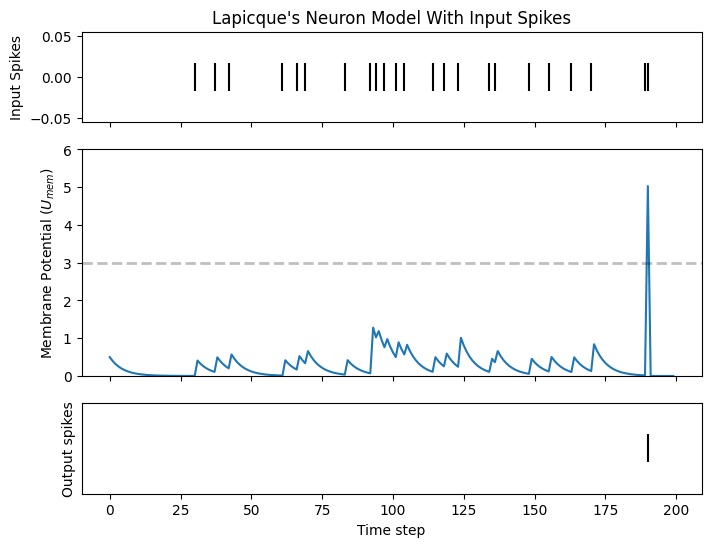

In [12]:
num_steps = 199
weights = torch.ones(6,6)*0.5

span = range(14,20)

for update in range(20):
    mem = torch.ones(1)*0.5
    spk_out = torch.zeros(1)
    mem_rec = [mem]
    spk_rec = [spk_out]
    spk_in = torch.zeros(1)
    
    for row in span:
        for col in span:
            spk_in = spk_in+weights[row-span[0],col-span[0]]*batch[0,:,1,row,col]
            
    # Neuron simulation
    for step in range(num_steps):
        spk_out, mem = lif(spk_in[step], mem)
        spk_rec.append(spk_out)
        mem_rec.append(mem)
    
    
    # convert lists to tensors
    mem_rec = torch.stack(mem_rec)
    spk_rec = torch.stack(spk_rec)
        
    deltas = torch.zeros(0)
    for row in span:
        for col in span:
            w_delta = torch.zeros(1)
            for out_spk_idx in spk_rec.reshape(len(spk_rec)).nonzero():
                for in_spk_idx in batch[0,max(0,out_spk_idx-10):min(199,out_spk_idx+10),1,row,col].nonzero():
                    delt = 1/(out_spk_idx-in_spk_idx) if out_spk_idx != in_spk_idx else torch.ones(1)*time_step
                    w_delta = w_delta + delt
            deltas = torch.cat((deltas, w_delta))
    #print(weights)
    weights = torch.nn.functional.normalize(weights+deltas.reshape(6,6))
    #print(weights)
    plot_spk_mem_spk(spk_in, mem_rec, spk_out, "Lapicque's Neuron Model With Input Spikes")

In [13]:
print(weights)

tensor([[0.4082, 0.4082, 0.4082, 0.4082, 0.4082, 0.4082],
        [0.3885, 0.4951, 0.3885, 0.3885, 0.3885, 0.3885],
        [0.4082, 0.4082, 0.4082, 0.4082, 0.4082, 0.4082],
        [0.5733, 0.3664, 0.3664, 0.3664, 0.3664, 0.3664],
        [0.4082, 0.4082, 0.4082, 0.4082, 0.4082, 0.4082],
        [0.4082, 0.4082, 0.4082, 0.4082, 0.4082, 0.4082]])


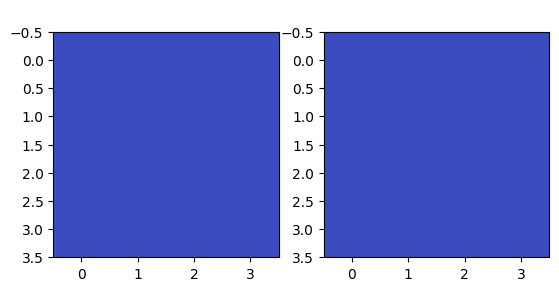

In [36]:
quick_animate([batch[0,:,0, 14:18, 14:18],batch[0,:,1, 14:18, 14:18]], frames=100)

In [ ]:
model.counter = 0
num_epochs = 5
loss_hist = []
weights_updates = []
#weights = list(weights)
# Outer training loop
num_evaluate = 25
switch_flag = False
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}", position=0, leave=True)):  
        
        labels = labels.to(device)
        ims = pos_neg_to_frame(images)[50:(74-50)*3+50:3].to(device)

        w = model.stdp_inshallah.weight.clone().detach()
        outputs = model(ims)
        if i%20==0:
            print(outputs)
        
        loss = criterion(outputs, labels)
        loss_hist.append(loss)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        weights_updates.append(model.stdp_inshallah.weight-w)
            
        if i == 0:
            with torch.no_grad():
                correct = 0
                total = 0
                predictions = []
                true = []
                for j, (test_images, test_labels) in enumerate(tqdm(test_loader, desc="Testing")):
                    if j == num_evaluate:
                        break
                    ims = pos_neg_to_frame(test_images)[50:(74-50)*3+50:3].to(device)
                    
                    #ims = ims[:, (test_labels == 1) | (test_labels==9)]
                    #test_labels = test_labels[(test_labels == 1) | (test_labels==9)]
                    #if ims.shape[1] == 0:
                    #    continue

                    test_labels = test_labels.to(device)
                    outputs = model(ims, record=False)
                    _, predicted = torch.max(outputs.data, 1)
                    total += test_labels.size(0)
                    correct += (predicted == test_labels).sum().item()
                    true.append(int(test_labels))
                    predictions.append(int(predicted))

                print(f"Predicted: {predictions}")
                print(f"Labels: {true}")
                    
                print(f'Accuracy of the network: {100*correct/total} %')
                
    model.counter=0
    weights_updates = torch.stack(weights_updates)
    torch.save(weights_updates, f"weight_delta{100*correct/total}.pt")
    torch.save(yy_record, f"inputs{100*correct/total}.pt")
    torch.save(model, f"modelF{100*correct/total}.pt")  
    weights_updates = []
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    #torch.save(model, f"model{100*correct/total}.pt")

Epoch 1:   0%|          | 0/323 [00:00<?, ?it/s]

tensor([[-10.5504,   8.5280, -17.1183,   4.0868,   4.3042, -13.1804, -17.6493,
         -13.7127, -14.7527,  -4.4201,   0.0472]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Testing:   0%|          | 0/26 [00:00<?, ?it/s]

Predicted: [10, 4, 8, 1, 9, 8, 5, 6, 9, 0, 5, 1, 1, 6, 4, 7, 9, 0, 4, 7, 1, 8, 3, 1, 0]
Labels: [6, 3, 8, 1, 4, 8, 5, 6, 9, 7, 5, 3, 1, 6, 10, 8, 9, 7, 3, 9, 1, 4, 10, 1, 7]
Accuracy of the network: 48.0 %
tensor([[-3.8282, -6.3580, -8.0759, -1.7701, -2.3677, -6.6871, -6.6801,  2.0700,
          2.0745,  2.3735,  1.0568]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ -1.4386, -11.2632,  -2.8071,  -9.6181, -11.5184,  -0.7320,   3.6857,
          -2.5218,   1.8561,  -0.9923,  -2.3453]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 0.2531, -6.3312, -4.2972, -6.0155, -2.9625, -3.5702, -0.5114,  0.7707,
          1.7320, -0.8683, -0.5553]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ -2.6523, -13.1212,   0.5380, -13.8806, -16.5115,   2.8918,   4.8421,
          -6.7113,  -1.4146,  -0.8137,  -2.9415]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ -5.6973, -10.8737,  -1.7916, -10.1618, -14.5942,   6.4684,   1.7292,
          -9.3690

Epoch 2:   0%|          | 0/323 [00:00<?, ?it/s]

tensor([[-5.1572, -1.9183, -3.7542, -2.5497, -2.3600, -4.0766, -6.1931, -5.0991,
         -3.5124,  3.9208,  1.4884]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Testing:   0%|          | 0/26 [00:00<?, ?it/s]

Predicted: [10, 4, 9, 1, 9, 0, 5, 6, 9, 0, 5, 1, 1, 6, 4, 8, 9, 3, 4, 9, 1, 8, 10, 1, 2]
Labels: [6, 3, 8, 1, 4, 8, 5, 6, 9, 7, 5, 3, 1, 6, 10, 8, 9, 7, 3, 9, 1, 4, 10, 1, 7]
Accuracy of the network: 52.0 %
tensor([[-1.7727, -5.7297, -2.3682, -3.6780, -5.4703, -1.9275, -1.9471, -0.9564,
          1.8183,  1.9864, -0.9769]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-13.0230,  -0.2974, -21.4774,   9.7643,   4.5579, -14.8061, -22.3761,
         -10.5632, -15.2882, -12.4407,  -0.2621]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ -3.8120, -15.1672,   2.6337, -20.9718, -24.9101,   7.5325,   6.6513,
         -13.1542,  -9.0082,  -7.8283,  -5.9231]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 1.1351, -2.6882, -3.7412, -0.5158, -1.0367, -3.1331, -3.1254,  1.9074,
         -1.3180, -2.3943, -1.3125]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ -3.4138, -11.1478,  -5.0041,  -7.3247,  -8.8480,  -3.6037,  -2.1098,
          -0.913